In [107]:
# load in our  libraries 
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [108]:
# Load in the train and test datasets
train = pd.read_csv('Train_Titanic.csv')
test = pd.read_csv('Test_Titanic.csv')

# store our passenger ID for easy access
PassengerID = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [109]:
#Data Cleaning/feature cleaning 
full_data = [train,test]




In [110]:
#Some features of my own that I have added in
# Gives  the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] =  test['Name'].apply(len)


test['Name_length'].head(3)


0    16
1    32
2    25
Name: Name_length, dtype: int64

In [111]:
# Feature that tells whether a passenegr  had a cabin on the titanic
train['Has_cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_cabin'] = test['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
test['Has_cabin'].head(3)


0    0
1    0
2    0
Name: Has_cabin, dtype: int64

In [112]:

# Feature Engineering steps from Sina
# Create new feature familysize as a combination of Sibsp and parch

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

dataset['FamilySize'].head(3)






0    1
1    2
2    1
Name: FamilySize, dtype: int64

In [113]:
#Create new feature IsAlone from FamilySize
for dataset in full_data:
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1 , 'IsAlone'] = 1
dataset['IsAlone'].head(3)
        
        

0    1
1    0
2    1
Name: IsAlone, dtype: int64

In [114]:
# Remove all NULLS in the Embarked Columns

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
    


In [115]:
#Remove all NULLs in the Fare column and create a new feature CategoricalFare
for dataset  in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [116]:
# Create  a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [117]:
# Define functions to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.',name)
    # If the tittle exists, extract and return it
    if title_search:
        return title_search.group(1)
    return ""

In [118]:
# Create a new feature Tittle, containing the tittle of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [119]:
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    


In [120]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female' : 0, 'male': 1}).astype(int)



In [121]:
# Mapping tittle

for dataset in full_data:
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


In [122]:
# Mapping Embarked
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)


In [123]:

#Mapping Fare 
for dataset in full_data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0

    dataset.loc[(dataset['Fare']> 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare']> 31, 'Fare'] = 3
             
    dataset['Fare'] = dataset['Fare'].astype(int)

In [124]:
# Mapping Age
for dataset in full_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [125]:
# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

In [126]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


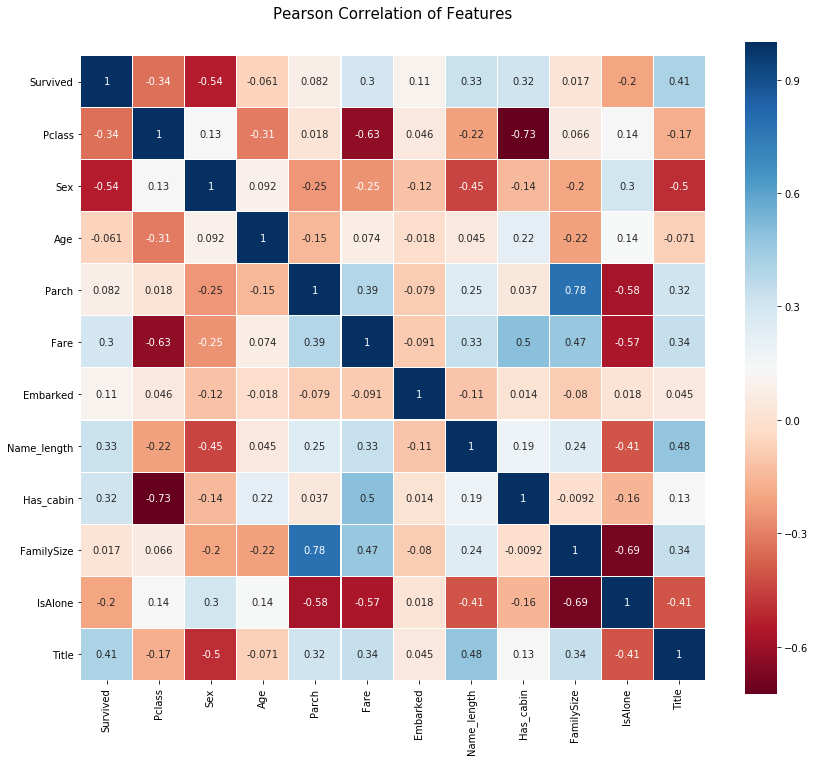

In [127]:
colormap = plt.cm.RdBu
plt.figure(figsize =(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidth=0.1 , vmax=1.0, square=True, cmap=colormap,linecolor = 'white',annot=True)

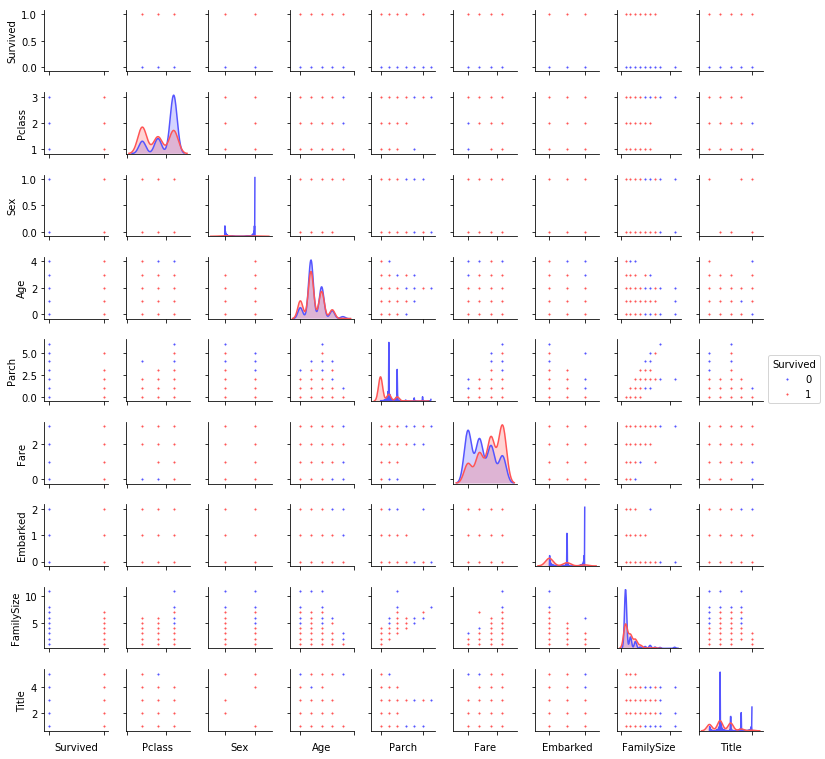

In [128]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex' , u'Age' , u'Parch', u'Fare' , u'Embarked', u'FamilySize' , u'Title']], hue= 'Survived', palette = 'seismic', size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

In [129]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold predication
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# CLass to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)

    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        
# Class to extend XGboost classifier

In [130]:
# Out -fold-predications

In [131]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test =  np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [132]:
# so now let us prepare five learning models as our first level classification. This models can be all convenientally invoked via
# sklearn library, are random forest classifier, Extra Trees classifier, AdaBoost classifier, gradient boosting classifier, support vetor machine

In [133]:
# put in our parameters for said classifiers
# Random forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start' : True,
    # 'max_features' : 0.2,
    'max_depth' : 6,
    'min_samples_leaf' : 2,
    'max_features' : 'sqrt',
    'verbose': 0
    
    
}

# Extra tree parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    # 'max_features' : 0.5,
    'max_depth': 8,
    'min_samples_leaf' : 2,
    'verbose': 0
    
}

# AdaBoost parameters
ada_params = {
    'n_estimators' : 500,
    'learning_rate': 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    # 'max_features' : 0.2,
    'max_depth' : 5,
    'min_samples_leaf': 2,
    'verbose': 0
}


# support vector classifier parameters
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}
    
    
    
    
    

In [134]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed =SEED, params=svc_params)

In [135]:
# Create Numpy arrays of train, test and target ( Survived) to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # create an array of the train
x_test = test.values # Create an  array of the test  data 

In [136]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")



Training is complete


In [138]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.1258629  0.19786616 0.0312586  0.02096107 0.07118967 0.02353949
 0.10921447 0.06459662 0.06742517 0.01378554 0.27430032]
[0.12098052 0.3776823  0.02857925 0.01724316 0.05554948 0.02874229
 0.04603379 0.0834594  0.04325778 0.02195457 0.17651746]
[0.034 0.01  0.014 0.068 0.038 0.008 0.688 0.014 0.052 0.002 0.072]
[0.07261421 0.02666541 0.10840947 0.02604176 0.08559097 0.06490901
 0.44132475 0.02684353 0.05853816 0.01904674 0.07001598]


In [142]:
rf_features = [0.1258629,  0.19786616, 0.0312586,  0.02096107, 0.07118967, 0.02353949,
 0.10921447, 0.06459662, 0.06742517, 0.01378554, 0.27430032]
et_features = [0.12098052, 0.3776823, 0.02857925, 0.01724316, 0.05554948, 0.02874229,
 0.04603379, 0.0834594, 0.04325778, 0.02195457, 0.17651746]
ada_features = [0.034, 0.01, 0.014, 0.068, 0.038, 0.008, 0.688, 0.014, 0.052, 0.002, 0.072]
gb_features = [0.07261421, 0.02666541, 0.10840947, 0.02604176, 0.08559097, 0.06490901,
 0.44132475, 0.02684353, 0.05853816, 0.01904674, 0.07001598]

In [147]:
# Create a dataframe from the lists containing the feature importance data for easy plotting via the plotly pacakage

cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols, 'Random Forest feature importances': rf_features, 'Extra Trees feature importances': et_features, 'AdaBoost feature importances': ada_features, 'Gradient Boost feature importances': gb_features})

In [149]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')